In [1]:
import pandas as pd
import numpy as np
from importlib import resources as impresources
from recurrent_health_events_prediction import configs
import os

## Check HMM Model

In [2]:
base_hmm_dir = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm"
model_name = "hmm_mimic_time_log_normal"

model_path = os.path.join(base_hmm_dir, model_name)
model_pickle = os.path.join(model_path, f"{model_name}.pkl")

In [3]:
from recurrent_health_events_prediction.model.utils import load_model
from recurrent_health_events_prediction.model.RecurrentHealthEventsHMM import RecurrentHealthEventsHMM

hmm: RecurrentHealthEventsHMM = load_model(model_pickle)

In [4]:
print(f"Model loaded from {model_pickle}")
print(f"Model name: {hmm.config['model_name']}")
print("Features:", hmm.features)

Model loaded from /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm/hmm_mimic_time_log_normal/hmm_mimic_time_log_normal.pkl
Model name: hmm_mimic_time_log_normal
Features: {'CHARLSON_INDEX': 'poisson', 'DISCHARGE_LOCATION_POST_ACUTE_CARE': 'bernoulli', 'LOG_DAYS_IN_ICU': 'gaussian', 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION': 'gaussian', 'LOG_NUM_DRUGS': 'gaussian'}


In [5]:
model_config_path = os.path.join(model_path, f"{model_name}_config.yaml")
print("Save model config in: ", model_config_path)

Save model config in:  /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm/hmm_mimic_time_log_normal/hmm_mimic_time_log_normal_config.yaml


In [6]:
from recurrent_health_events_prediction.utils.general_utils import save_yaml_config

save_yaml_config(hmm.config, model_config_path)

In [7]:
hmm.get_initial_probabilities()

array([0.21921517, 0.30230385, 0.47848102], dtype=float32)

In [8]:
labels = hmm.config["hidden_state_labels"]

# Display the DataFrame with HTML styling
distributions_params_df = hmm.get_features_dist_df(True).sort_values(
    by='State Label', key=lambda col: [labels.index(label) for label in col]
)

styled_df = distributions_params_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12px'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('font-size', '12px'), ('text-align', 'center')]}]
).set_properties(**{'border': '1px solid black', 'padding': '5px'})

styled_df

In [ ]:
sequences_up_to_last_readmission_df = pd.read_csv("/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm/hmm_multiple_emissions_no_time/events_up_to_last_readmission.csv")

In [9]:
sequences_up_to_last_readmission_list = hmm.transform_dataframe(sequences_up_to_last_readmission_df)

In [10]:
from recurrent_health_events_prediction.model.utils import predict_partial_obs_given_history_proba, predict_single_partial_obs_proba

hidden_states_seq_list = []
for sequence in sequences_up_to_last_readmission_list:
    if len(sequence) == 1:
        obs = sequence[0]
        state_probs = predict_single_partial_obs_proba(hmm.model, obs)
        hidden_states_seq_list.append([state_probs])  # shape: [1 x num_states]
    else:
        hidden_states = predict_partial_obs_given_history_proba(hmm.model, sequence[0:-1], sequence[-1], True)
        hidden_states_seq_list.append(hidden_states)

In [13]:
subject_ids = sequences_up_to_last_readmission_df["SUBJECT_ID"].drop_duplicates().values
subject_ids = subject_ids.tolist()

In [17]:
from operator import index

subject_id = 68
subject_index = subject_ids.index(subject_id)
hidden_probs_sequence_subject = hidden_states_seq_list[subject_index]

In [18]:
hidden_probs_sequence_subject

[[1.652182800171431e-05,
  0.7562467455863953,
  0.11163867264986038,
  0.13209813833236694]]

In [21]:
hidden_states_mapping = hmm.get_hidden_state_labels()
hidden_states_mapping

{2: 'very_high', 0: 'high', 1: 'medium', 3: 'low'}

In [23]:
from recurrent_health_events_prediction.training.utils import add_pred_state_to_df, add_pred_prob_states_to_df

events_up_to_last_readmission_last_obs_masked_df = add_pred_prob_states_to_df(events_up_to_last_readmission_last_obs_masked_df, hidden_states_seq_list, labels=hidden_states_mapping)
events_up_to_last_readmission_last_obs_masked_df

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,HAS_DIABETES,HAS_COPD,...,LOG_MED_PAST_TIMES_TO_HOSP,LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION,LOG_NUM_PREV_HOSPITALIZATIONS,IS_LAST_EVENT,IS_HISTORICAL_EVENT,READMISSION_TIME_CAT,PROB_HIDDEN_RISK_HIGH,PROB_HIDDEN_RISK_MEDIUM,PROB_HIDDEN_RISK_VERY_HIGH,PROB_HIDDEN_RISK_LOW
0,68,170467,2173-12-15 16:16:00,2174-01-03 18:30:00,EMERGENCY,19.093056,4,"['other', 'aids', 'renal_disease', 'congestive...",False,False,...,NaN,NaN,0.000000,1,0,0,0.188558,0.261639,1.593809e-01,3.904224e-01
1,105,161160,2189-01-28 16:57:00,2189-02-02 16:40:00,EMERGENCY,4.988194,2,"['other', 'congestive_heart_failure']",False,False,...,NaN,NaN,0.000000,1,0,0,0.188558,0.261639,1.593809e-01,3.904224e-01
2,109,183350,2137-11-04 19:36:00,2137-11-21 18:13:00,EMERGENCY,16.942361,3,"['other', 'rheumatic_disease', 'renal_disease']",False,False,...,NaN,4.990296,0.000000,0,1,2,0.066443,0.870027,8.354552e-04,6.269462e-02
3,109,128755,2138-04-16 17:44:00,2138-04-19 16:00:00,EMERGENCY,2.927778,4,"['other', 'rheumatic_disease', 'cerebrovascula...",False,False,...,4.990296,6.462862,0.693147,0,1,2,0.000027,0.142083,3.304400e-07,8.578902e-01
4,109,164029,2140-01-19 13:25:00,2140-01-21 13:25:00,EMERGENCY,2.000000,3,"['other', 'rheumatic_disease', 'renal_disease']",False,False,...,5.976189,2.528392,1.098612,0,1,0,0.223635,0.000358,7.760070e-01,8.851026e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3998,99562,129689,2183-02-02 15:13:00,2183-02-18 13:28:00,URGENT,15.927083,5,"['other', 'peripheral_vascular_disease', 'pept...",False,False,...,NaN,NaN,0.000000,1,0,0,0.188558,0.261639,1.593809e-01,3.904224e-01
3999,99613,175391,2152-11-03 18:12:00,2152-11-14 15:43:00,EMERGENCY,10.896528,2,"['other', 'chronic_pulmonary_disease']",False,True,...,NaN,NaN,0.000000,1,0,1,0.188558,0.261639,1.593809e-01,3.904224e-01
4000,99923,164914,2201-02-23 20:42:00,2201-03-03 16:00:00,EMERGENCY,7.804167,4,"['other', 'severe_liver_disease', 'mild_liver_...",False,False,...,NaN,NaN,0.000000,1,0,1,0.188558,0.261639,1.593809e-01,3.904224e-01
4001,99982,151454,2156-11-28 11:56:00,2156-12-08 13:45:00,EMERGENCY,10.075694,2,"['other', 'congestive_heart_failure']",False,False,...,NaN,3.372598,0.000000,0,1,0,0.793458,0.023187,1.833444e-01,1.080489e-05


## Check Survival Model

In [1]:
model_path = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival_based/cox_proportional_hazard_model_with_hmm_strata/cox_proportional_hazard_model_with_hmm_strata.pkl"
from recurrent_health_events_prediction.model import NextEventPredictionModel
from recurrent_health_events_prediction.model.utils import load_model
cox_model: NextEventPredictionModel = load_model(model_path)

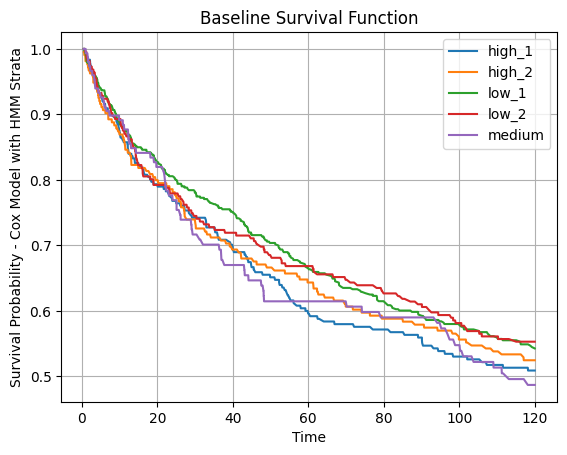

In [5]:
ax = cox_model.model.baseline_survival_.plot()
ax.set_title("Baseline Survival Function")
ax.set_xlabel("Time")
ax.set_ylabel("Survival Probability - Cox Model with HMM Strata")
ax.grid(True)